In [1]:
import tensorflow as tf
import numpy as np
import glob
import keras as k
from keras.preprocessing.image import ImageDataGenerator
import glob
from keras import Input
from keras.layers import Lambda,LeakyReLU,Conv2D,Dense,Dropout,Conv2DTranspose,MaxPooling2D,concatenate,UpSampling2D,BatchNormalization
from keras.models import Model
import cv2
import PIL
import matplotlib.pyplot as plt
import skimage.io as io
import pandas as pd
from keras.preprocessing.image import array_to_img,load_img,img_to_array
from skimage import io
import os
from skimage.color import rgb2gray
from scipy import ndimage
!pip install MedPy
from medpy.io import load

In [39]:
height=240
width=240
channle=1

inputs=Input((height,width,channle))

c1=Conv2D(64,3,padding="same",activation="relu",kernel_initializer="he_normal")(inputs)
c1=BatchNormalization()(c1)
c1=Conv2D(64,3,padding="same",activation="relu",kernel_initializer="he_normal")(c1)
p1=MaxPooling2D()(c1)

c2=Conv2D(128,3,padding="same",activation="relu",kernel_initializer="he_normal")(p1)
# c2=BatchNormalization()(c2)
c2=Conv2D(128,3,padding="same",activation="relu",kernel_initializer="he_normal")(c2)
p2=MaxPooling2D()(c2)

c3=Conv2D(256,3,padding="same",activation="relu",kernel_initializer="he_normal")(p2)
# c3=BatchNormalization()(c3)
c3=Conv2D(256,3,padding="same",activation="relu",kernel_initializer="he_normal")(c3)
p3=MaxPooling2D()(c3)

c4=Conv2D(512,3,padding="same",activation="relu",kernel_initializer="he_normal")(p3)
# c4=BatchNormalization()(c4)
c4=Conv2D(512,3,padding="same",activation="relu",kernel_initializer="he_normal")(c4)
drop4=Dropout(.5)(c4)
p4=MaxPooling2D()(drop4)

c5=Conv2D(1024,3,padding="same",activation="relu",kernel_initializer="he_normal")(p4)
# c5=BatchNormalization()(c5)
c5=Conv2D(1024,3,padding="same",activation="relu",kernel_initializer="he_normal")(c5)
drop5=Dropout(.5)(c5)

u6=Conv2D(512,2,activation="relu",padding="same",kernel_initializer="he_normal")(UpSampling2D()(drop5))
merge6=concatenate([u6,drop4])
c6=Conv2D(512,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge6)
c6=BatchNormalization()(c6)
c6=Conv2D(512,3,activation="relu",padding="same",kernel_initializer="he_normal")(c6)

u7=Conv2D(256,2,activation="relu",kernel_initializer="he_normal",padding="same")(UpSampling2D()(c6))
merge7=concatenate([u7,c3])
c7=Conv2D(256,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge7)
# c7=BatchNormalization()(c7)
c7=Conv2D(256,3,activation="relu",padding="same",kernel_initializer="he_normal")(c7)

u8=Conv2D(128,2,activation="relu",padding="same",kernel_initializer="he_normal")(UpSampling2D()(c7))
merge8=concatenate([c2,u8])
c8=Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge8)
# c8=BatchNormalization()(c8)
c8=Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(c8)

u9=Conv2D(64,2,activation="relu",padding="same",kernel_initializer="he_normal")(UpSampling2D()(c8))
merge9=concatenate([u9,c1])
c9=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge9)
# c9=BatchNormalization()(c9)
c9=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(c9)

c9=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(c9)
output=Conv2D(1,1,activation="sigmoid")(c9)

model=Model(inputs,output)


In [40]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

In [41]:
# !unzip "/content/drive/My Drive/brain-tumor-segmentation-in-mri-brats-2015.zip"

images=[]
labels=[]

path="/content/train/HGG/"
list_file=os.listdir(path)
for file in list_file:
  list_=os.listdir(path+file+"/")
  list_=sorted(list_)
  image,_=load(path+file+"/"+list_[0])
  label,_=load(path+file+"/"+list_[4])
  for i in range(image.shape[2]):
    images.append(image[:,:,i])
    labels.append(label[:,:,i])


In [11]:
path="/content/test/HGG_LGG/"
list_test=os.listdir(path)
image_test=[]
for file in list_test:
  list_=sorted(os.listdir(path+file))
  image,_=load(path+file+"/"+list_[2])
  for i in range(image.shape[2]):
    image_test.append(image[:,:,i])
    if i+1%100==0:
      break

In [42]:
images=np.reshape(images,(34100,240,240,1))
labels=np.reshape(labels,(34100,240,240,1))

In [44]:
model.fit(images,labels,epochs=2,batch_size=32)
model.save_weights("u_net_weight.h5")

Epoch 1/2
1066/1066 [==============================] - 952s 893ms/step - loss: 0.0672 - acc: 0.9843
Epoch 2/2
1066/1066 [==============================] - 952s 893ms/step - loss: 0.0587 - acc: 0.9790


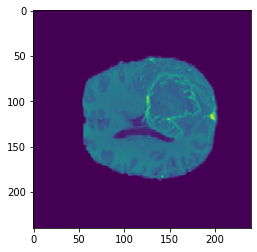

In [127]:
image,_=load("/content/test/HGG_LGG/brats_2013_pat0134_1/VSD.Brain.XX.O.MR_T1c.54259.mha")
i=90
plt.imshow(image[:,:,i])
plt.imsave("image1.png",image[:,:,i])

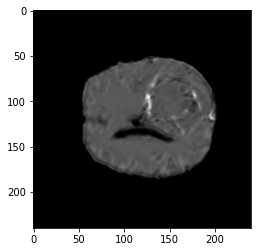

In [128]:
image_pred=np.reshape(image[:,:,i],(1,240,240,1))
image_pred=model.predict(image_pred)
image_pred=np.reshape(image_pred,(240,240))
plt.imshow(image_pred,"gray")
plt.imsave("pred_image1.png",image_pred,cmap="gray")

In [129]:
!cp "/content/u_net_weight.h5" -r "/content/drive/My Drive"